In [ ]:
import gc
import warnings
warnings.filterwarnings("ignore")
import IPython

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import neptune.new as neptune

from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_percentage_error

In [ ]:
def display(*dfs):
    for df in dfs:
        IPython.display.display(df)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def preprocess_datetime(df, time_columns):
    for t in time_columns:
        df[t+'_month'] = df[t].dt.month
        df[t+'_is_month_start'] = df[t].dt.is_month_start.astype('int')
        df[t+'_is_month_end'] = df[t].dt.is_month_end.astype('int')
        df[t+'_day'] = df[t].dt.day
        df[t+'_hour'] = df[t].dt.hour
        df[t+'_dayofweek'] = df[t].dt.dayofweek
        df[t+'_is_weekend'] = (df[t+'_dayofweek'] >= 5).astype('int')
        df[t+'_quarter'] = df[t].dt.quarter

def replace_na_on_missing(x): return np.where(x.isna(), 'missing', x)

EPSILON = 1e-38

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


class UserDefinedMetric_mdape(object):
    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return False

    def evaluate(self, approxes, target, weight):
        # approxes is a list of indexed containers
        # (containers with only __len__ and __getitem__ defined),
        # one container per approx dimension.
        # Each container contains floats.
        # weight is a one dimensional indexed container.
        # target is a one dimensional indexed container.
        
        # weight parameter can be None.
        # Returns pair (error, weights sum)
        error = mdape(approxes[0], target)
        return error, target.shape[0]

    
    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error#/(weight + EPSILON)

In [ ]:
def get_submittion(preds, df_test):
    submittion = df_test[['transaction_id']]
    submittion['price'] = preds
    submittion.to_csv('submittion.csv', index=False)


def get_data():
    df_2017 = pd.read_csv('data/2017.csv')
    df_2018 = pd.read_csv('data/2018.csv')
    df_test = pd.read_csv('data/2019.csv')
    print(df_2017.shape, df_2018.shape, df_test.shape)

    df_ini = pd.concat([df_2017, df_2018])
    assert df_2017.shape[0] + df_2018.shape[0] == df_ini.shape[0]

    df_ini = reduce_mem_usage(df_ini)
    df_test = reduce_mem_usage(df_test)
    return  df_ini, df_test, #df


features_str = ['epc_windows_description',
                'epc_walls_description',
                'epc_roof_description',
                ]
features_address = ['street', 'city', 
                'building_number', 'flat',
                'building_name',
                'postcode_sector',
                'postcode']

def preprocess_data_main(df):
    df['created'] = pd.to_datetime(df.created)
    preprocess_datetime(df, ['created'])
    features_objects = df.select_dtypes('object').columns
    features_cat = [f for f in features_objects \
                    if f not in features_str + features_address + ['transaction_id']]
    df[features_cat] = df[features_cat].astype('category')
    df[features_str] = df[features_str].astype('string')

    to_drop = ['created_month', 'created_quarter', 'created_hour']
    df.drop(to_drop, axis=1, inplace=True)
    features_num = df.select_dtypes(include=['float16', 'float32', 'int32', 'int64']).columns
    assert len(features_cat) + len(features_str) + len(features_address)\
        + len(features_num) ==  df.shape[1] - 2 # transaction_id, created
    return features_cat, features_num


In [ ]:
df_ini, df_test = get_data()
np.random.seed(2021)
idx = np.random.choice(np.arange(0, df_ini.shape[0]),
                                size=100_000, replace=False)
df = df_ini.iloc[idx]
features_cat, features_num = preprocess_data_main(df)
_ = preprocess_data_main(df_test)
df_test['price'] = np.nan

(992212, 43) (986565, 43) (28323, 42)
Mem. usage decreased to 471.78 Mb (29.0% reduction)
Mem. usage decreased to  6.43 Mb (29.2% reduction)


In [ ]:
df[features_cat] = df[features_cat].apply(replace_na_on_missing)
df_test[features_cat] = df_test[features_cat].apply(replace_na_on_missing)

cv_folds = TimeSeriesSplit(n_splits=5)

cv_idx = list(cv_folds.split(df, df.price))[-1]
# df.city = df.city.astype('category')
train = df.iloc[cv_idx[0]]
val = df.iloc[cv_idx[1]]


In [ ]:
# _ = preprocess_data_main(df_ini)
# df_ini[features_cat] = df_ini[features_cat].apply(lambda x: np.where(x.isna(), 'missing', x))

### Preprocee text features to categorical

In [ ]:
# def find_by_template_and_replace(temp, df, f, name=''):
#     print(f'''rel. % of samples with cyfartalog: \
# {df[f].dropna().str.extract(tmp).notna().sum()/df.shape[0]*100}''')
#     df[name] = df[f].str.extract(tmp).apply(lambda x: np.where(x.isna(), np.nan,x) )
#     display(df[name].dropna().unique())
#     df[name] = df[name].astype('float')
#     df[f] = df[f].str.replace(tmp, '')

In [ ]:
# f = 'epc_walls_description'

# tmp = '\|Trawsyriannedd thermol cyfartalog =*\s*(\d.*\d*) W/m.*K'
# find_by_template_and_replace(tmp, df, f, 'wall_cyfartalog')
# tmp = 'transmittance =*\s*(\d.*\d*) W/m.*K'
# find_by_template_and_replace(tmp, df, f, 'wall_transmittance')

In [ ]:
# temp = df[f].str.replace('+', ',').str.replace('.', ',').str.replace(', ',',')\
#             .str.split(',', expand=True)
# print(f'% of nan is each col\n{temp.notna().sum(axis=0)/temp.shape[0]*100}')
# temp = temp.iloc[:,:7].apply(replace_na_on_missing).astype('category')
# temp.columns = f + temp.columns.astype('string')
# df = pd.concat((df, temp), axis=1)
# features_cat.extend(temp.columns)
# gc.collect();

In [ ]:
# f = 'epc_roof_description'
# tmp = '(\d+)\+*\s*mm loft '
# find_by_template_and_replace(temp, df, f, 'roof_loft')
# tmp = '\|Trawsyriannedd thermol cyfartalog \d.\d\d'
# df[f] = df[f].str.replace(tmp, '')
# tmp = 'transmittance =*\s*(\d\.*\d*) W/m.*K'
# find_by_template_and_replace(temp, df, f, 'roof_transmittance')


In [ ]:
# temp = df[f].str.replace('+', ',').str.replace('.', ',').str.replace(', ',',')\
#             .str.split(',', expand=True)
# print(f'% of nan is each col\n{temp.notna().sum(axis=0)/temp.shape[0]*100}')
# temp = temp.iloc[:,:5].apply(replace_na_on_missing).astype('category')
# temp.columns = f + temp.columns.astype('string')
# df = pd.concat((df, temp), axis=1)
# features_cat.extend(temp.columns)
# gc.collect();

In [ ]:
# f = 'epc_windows_description'
# df[f] = df[[f]].apply(replace_na_on_missing).values
# features_cat.append(f)
# # features_str.remove(f)

## Catboost model

In [ ]:
def model_Catboost(df, df_test, cv_folds, num_iter, params_neptune, paramds_add,
                  flag_val=False, flag_test=False, flag_neptune=False, name=''):

   to_drop = ['transaction_id', 'created', 'price'] + features_str + features_address
#    print(df.iloc[0][features_cat])
   data = Pool(df.drop(to_drop, axis=1), df.price, cat_features=features_cat)
#    test = Pool(df_test.drop(to_drop, axis=1), cat_features=features_cat)

   if flag_neptune:
        run = neptune.init(project='declot/Enbysis-UK-Rental')
        run['parameters'] = params_neptune
        run["sys/name"] = name
        run["sys/tags"].add(['Catboost'])

   cv_data = cv(data, dict(**params_neptune, **params_add), iterations=num_iter, folds=cv_folds,
      shuffle=False, as_pandas=True)
   if flag_neptune:
        run['cv/mdape'] = cv_data[f'test-{UserDefinedMetric_mdape.__name__}-mean'].min()
        run['cv/mdape_iter'] = cv_data.iterations[cv_data[f'test-{UserDefinedMetric_mdape.__name__}-mean'].idxmin()]

   if flag_val:
        train = Pool(df.iloc[cv_idx[0]].drop(to_drop, axis=1), df.iloc[cv_idx[0]].price, 
               cat_features=features_cat)
        val = Pool(df.iloc[cv_idx[1]].drop(to_drop, axis=1), df.iloc[cv_idx[1]].price, 
            cat_features=features_cat)

        model = CatBoostRegressor(**params_neptune, **params_add, verbose=0)
        model.fit(train, eval_set=val)
        preds = model.predict(val)
        metrics = mdape(val.get_label(), preds), \
                mean_absolute_percentage_error(val.get_label(), preds)
        print(f'''\nval mdape: {metrics[0]}\
                val mape: {metrics[1]}''')
        if flag_neptune: 
            run['val/mdape'], run['val/mape'] = metrics
            run.stop()

   if flag_test:
        model = CatBoostRegressor(**params_neptune, **params_add, verbose=False)
        model.fit(data, verbose=False)
        preds = model.predict(test)
        # pd.Series(preds).plot(kind='hist', xlim=(0, 2.5e6), density=1, bins=200, alpha=0.5)
        # train.price.plot(kind='hist', xlim=(0, 2.5e6), density=1, bins=5000, alpha=0.5)
        get_submittion(preds, df_test)

   if flag_val: return model

   

In [ ]:
df[features_address].nunique().sort_values()

city                 348
flat                 708
building_number     1943
postcode_sector     7934
building_name      10746
street             53218
postcode           89696
dtype: int64

In [ ]:
f = 'city'
features_address.remove(f)
features_cat.append(f)

In [ ]:
# name = 'add text feat as cat'
name = ''
num_iter = 100
params_neptune = dict(loss_function = 'MAE',
                     iterations = num_iter,
              learning_rate = 0.5,
              depth = 6,
              l2_leaf_reg = 1,
              bagging_temperature = 1,
              max_leaves = 64,
              min_data_in_leaf = 32,
              one_hot_max_size=2,
              has_time = True,
              rsm = 0.7, # num features
              nan_mode = 'Min',
              fold_permutation_block = 1,
              leaf_estimation_method = 'Exact', #'Gradient', #'Newton', 
               boosting_type = 'Plain', #'Ordered'
               langevin = True,
               diffusion_temperature = 10_000,
             )
metric = UserDefinedMetric_mdape()#'MedianAbsoluteError',#'MAPE', #'MedianAbsoluteError', 
params_add = dict(eval_metric =  metric,
                  cat_features = features_cat,
                  random_seed = 2021,
                  metric_period = 10,
                 )

model = model_Catboost(df, df_test, cv_folds, num_iter, params_neptune, params_add, 
               flag_val=True, flag_test=False, flag_neptune=False, name=name)
gc.collect()

0:	learn: 1.0000000	test: 1.0062678	best: 1.0062678 (0)
10:	learn: 0.2220007	test: 0.2227197	best: 0.2227197 (10)
20:	learn: 0.2089035	test: 0.2110320	best: 0.2110320 (20)
30:	learn: 0.1995634	test: 0.2043951	best: 0.2043951 (30)
40:	learn: 0.1932845	test: 0.2011042	best: 0.2011042 (40)
50:	learn: 0.1883800	test: 0.1990100	best: 0.1990100 (50)
60:	learn: 0.1846925	test: 0.1970178	best: 0.1970178 (60)
70:	learn: 0.1813283	test: 0.1956427	best: 0.1956427 (70)
80:	learn: 0.1787007	test: 0.1950055	best: 0.1950055 (80)
90:	learn: 0.1762637	test: 0.1940181	best: 0.1940181 (90)	total: 18s	remaining: 1.78s
99:	learn: 0.1738810	test: 0.1938095	best: 0.1938095 (99)	total: 19.9s	remaining: 0us

val mdape: 0.18372923200201224                val mape: 0.8754544978134178


24

In [ ]:
# df.iloc[cv_idx[1]].index.unique()

Int64Index([656163, 796926, 496832, 151208, 753977, 948796, 691887, 456387,
            294875, 612365,
            ...
            535476, 139129, 298765, 735774, 514101,  16748, 468556,  22313,
            649112, 543092],
           dtype='int64', length=16582)

<AxesSubplot:xlabel='true', ylabel='pred'>

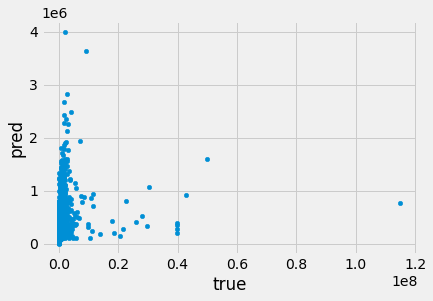

In [ ]:
to_drop = ['transaction_id', 'created', 'price'] + features_str + features_address

pred = model.predict(Pool(df.iloc[cv_idx[1]].drop(to_drop, axis=1), df.iloc[cv_idx[1]].price, 
            cat_features=features_cat))
data = pd.concat([df.iloc[cv_idx[1]].price.reset_index(drop=True), pd.Series(pred)], axis=1)
data.columns = ['true', 'pred']
data.plot.scatter(x='true', y='pred')

In [ ]:
to_drop = ['transaction_id', 'created', 'price'] + features_str + features_address

pd.Series(model.get_feature_importance(), df.drop(to_drop, axis=1).columns).sort_values()

created_is_weekend                 0.000000
created_is_month_start             0.000000
epc_current_energy_rating          0.005809
created_day                        0.009543
created_is_month_end               0.014183
epc_glazed_area                    0.017857
floor_level                        0.024045
epc_hot_water_cost_current         0.040479
created_dayofweek                  0.045177
epc_flat_storey_count              0.049547
epc_potential_energy_rating        0.066789
epc_number_open_fireplaces         0.082434
epc_built_form                     0.134623
epc_property_type                  0.218808
epc_floor_height                   0.272917
epc_walls_energy_eff               0.326557
epc_heating_cost_current           0.344968
closestpark                        0.354117
number_of_rooms                    0.410215
closeststop                        0.520003
epc_windows_energy_eff             0.816737
ppd_category                       0.828122
closestschool                   

transaction_id                            object
created                           datetime64[ns]
price                                      int32
number_of_rooms                          float16
total_floor_area                         float16
epc_energy_consumption_current           float32
epc_lighting_cost_current                float16
epc_heating_cost_current                 float16
epc_hot_water_cost_current               float16
epc_flat_storey_count                    float16
epc_number_open_fireplaces               float16
epc_floor_height                         float16
latitude                                 float16
longitude                                float16
closeststop                              float16
crimesin3km_antisocial                   float16
closestschool                            float16
closestpark                              float16
address_id                                 int32
distance_center                          float16
created_is_month_sta

In [ ]:
df['wall_cyfartalog'].apply(replace_na_on_missing)

377397    True
569014    True
696207    True
861218    True
538756    True
          ... 
16748     True
468556    True
22313     True
649112    True
543092    True
Name: wall_cyfartalog, Length: 100000, dtype: bool

### LightGbm

In [ ]:
# temp = df.copy()
# temp[features_cat] = temp[features_cat].astype('category').apply(lambda x: x.cat.codes) 
# train = temp.iloc[cv_idx[0]]
# val = temp.iloc[cv_idx[1]]
# train = lgb.Dataset(train.drop(to_drop, axis=1), label=train.price, 
#                     categorical_feature=features_cat)
# val = lgb.Dataset(val.drop(to_drop, axis=1), label=val.price,
#                   free_raw_data=False,
#                   categorical_feature=features_cat)

# params_lgb = dict(objective='regression', metric=['mape', 'rmse'],
#                   learning_rate=0.0005, num_leaves = 30, min_data_in_leaf=20, 
#                   bagging_fraction=1,feature_fraction_bynode=1,
#                   lambda_l1=1, lambda_l2=10, min_gain_to_split=0. )
# bst = lgb.train(params_lgb, train, num_boost_round=20, valid_sets=[val],\
#                 verbose_eval=10)

# preds = bst.predict(val.get_data())
# mdape(val.get_label(), preds)


In [ ]:
# preds, val.get_label()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93dfd834-f8d5-41c6-9de5-c4f79b8a1815' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>